# UCI mHealth Classification - CNN
- https://archive.ics.uci.edu/dataset/319/mhealth+dataset

#### 데이터 구조
- 10명의 참가자별로 mHealth_subject<SUBJECT_ID>.log 파일 존재
- 가속도, 자이로, 자기장, 심전도 -> 총 23개의 feature

#### 라벨
0. Other
1. Standing still
2. Sitting and relaxing
3. Lying down
4. Walking
5. Climbing stairs
6. Waist bends forward
7. Frontal elevation of arms
8. Knees bending (crouching)
9. Cycling
10. Jogging
11. Running
12. Jump front & back


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Conv1D, BatchNormalization, ReLU, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
base_dir = "/content/drive/MyDrive/AI_data/MHEALTHDATASET"
dfs = []
col_names = [
    'acc_chest_x', 'acc_chest_y', 'acc_chest_z',
    'ecg1', 'ecg2',
    'acc_left_ankle_x', 'acc_left_ankle_y', 'acc_left_ankle_z',
    'gyro_left_ankle_x', 'gyro_left_ankle_y', 'gyro_left_ankle_z',
    'magnet_left_ankle_x', 'magnet_left_ankl6e_y', 'magnet_left_ankle_z',
    'acc_right_arm_x', 'acc_right_arm_y', 'acc_right_arm_z',
    'gyro_right_arm_x', 'gyro_right_arm_y', 'gyro_right_arm_z',
    'magnet_right_arm_x', 'magnet_right_arm_y', 'magnet_right_arm_z',
    'label', 'subject'
]

for i in range(1, 11):
    path = os.path.join(base_dir, f"mHealth_subject{i}.log")
    df_i = pd.read_csv(path, sep='\t', header=None)
    df_i['subject'] = i
    dfs.append(df_i)

df = pd.concat(dfs, ignore_index=True)
df = df.dropna(how='any', axis=0)
df.columns = col_names
df

,acc_chest_x,acc_chest_y,acc_chest_z,ecg1,ecg2,acc_left_ankle_x,acc_left_ankle_y,acc_left_ankle_z,gyro_left_ankle_x,gyro_left_ankle_y,...,acc_right_arm_y,acc_right_arm_z,gyro_right_arm_x,gyro_right_arm_y,gyro_right_arm_z,magnet_right_arm_x,magnet_right_arm_y,magnet_right_arm_z,label,subject
0,-9.8184,0.009971,0.29563,0.004186,0.004186,2.1849,-9.6967,0.63077,0.103900,-0.84053,...,-4.5781,0.187760,-0.449020,-1.01030,0.034483,-2.35000,-1.610200,-0.030899,0,1
1,-9.8489,0.524040,0.37348,0.004186,0.016745,2.3876,-9.5080,0.68389,0.085343,-0.83865,...,-4.3198,0.023595,-0.449020,-1.01030,0.034483,-2.16320,-0.882540,0.326570,0,1
2,-9.6602,0.181850,0.43742,0.016745,0.037677,2.4086,-9.5674,0.68113,0.085343,-0.83865,...,-4.2772,0.275720,-0.449020,-1.01030,0.034483,-1.61750,-0.165620,-0.030693,0,1
3,-9.6507,0.214220,0.24033,0.079540,0.117220,2.1814,-9.4301,0.55031,0.085343,-0.83865,...,-4.3163,0.367520,-0.456860,-1.00820,0.025862,-1.07710,0.006945,-0.382620,0,1
4,-9.7030,0.303890,0.31156,0.221870,0.205130,2.4173,-9.3889,0.71098,0.085343,-0.83865,...,-4.1459,0.407290,-0.456860,-1.00820,0.025862,-0.53684,0.175900,-1.095500,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215740,-9.2476,-0.248070,-2.62230,0.230250,0.234430,1.7849,-9.8287,0.29725,-0.341370,-0.90056,...,-8.9071,0.294230,0.041176,-0.99384,-0.480600,2.40890,7.496100,7.915500,0,10
1215741,-9.4632,-0.073513,-2.11190,0.276300,0.284670,1.8687,-9.8766,0.46236,-0.341370,-0.90056,...,-8.7455,0.448140,0.041176,-0.99384,-0.480600,1.69450,7.866000,7.897500,0,10
1215742,-9.4011,-0.144580,-3.02350,0.288850,0.301410,1.6928,-9.9290,0.16631,-0.341370,-0.90056,...,-9.1155,0.450480,0.041176,-0.99384,-0.480600,1.15770,8.052800,7.884900,0,10
1215743,-9.3732,-0.026252,-2.70760,0.351650,0.347460,1.5279,-9.6306,0.30458,-0.341370,-0.90056,...,-9.1441,0.594880,0.041176,-0.99384,-0.480600,0.27441,9.487900,5.325800,0,10


In [ ]:
df.label.value_counts()

,count
label,
0,872550
1,30720
2,30720
3,30720
4,30720
9,30720
5,30720
11,30720
10,30720


In [ ]:
# downsampling
from sklearn.utils import resample

df_majority = df[df.label==0]
df_minorities = df[df.label!=0]

df_majority_downsampled = resample(df_majority, n_samples=30000, random_state=42)
df = pd.concat([df_majority_downsampled, df_minorities])
df.label.value_counts()

,count
label,
1,30720
3,30720
2,30720
4,30720
9,30720
11,30720
5,30720
10,30720
0,30000


In [ ]:
# df.to_csv('/content/drive/MyDrive/AI_data/MHEALTHDATASET/mhealth_resampled_data.csv',index = False)


In [ ]:
df.isnull().sum()

,0
acc_chest_x,0
acc_chest_y,0
acc_chest_z,0
ecg1,0
ecg2,0
acc_left_ankle_x,0
acc_left_ankle_y,0
acc_left_ankle_z,0
gyro_left_ankle_x,0
gyro_left_ankle_y,0


In [ ]:
# 피험자 1-6: 훈련, 피험자 7-8: 검증, 피험자 8-9: 테스트
train = df[~df['subject'].isin([7, 8, 9, 10])]
val = df[df['subject'].isin([7, 8])]
test = df[df['subject'].isin([9, 10])]

train.shape, val.shape, test.shape

((226128, 25), (73326, 25), (73741, 25))

In [ ]:
X_train = train.drop(['label','subject'], axis=1)
y_train = train['label']

X_val = val.drop(['label','subject'], axis=1)
y_val = val['label']

X_test = test.drop(['label','subject'], axis=1)
y_test = test['label']

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((226128, 23), (226128,), (73326, 23), (73326,), (73741, 23), (73741,))

In [ ]:
sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(sc.fit_transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(sc.fit_transform(X_test), columns=X_train.columns)

X_train

,acc_chest_x,acc_chest_y,acc_chest_z,ecg1,ecg2,acc_left_ankle_x,acc_left_ankle_y,acc_left_ankle_z,gyro_left_ankle_x,gyro_left_ankle_y,...,magnet_left_ankle_z,acc_right_arm_x,acc_right_arm_y,acc_right_arm_z,gyro_right_arm_x,gyro_right_arm_y,gyro_right_arm_z,magnet_right_arm_x,magnet_right_arm_y,magnet_right_arm_z
0,-0.087384,-0.180627,-0.786215,0.007915,-0.011472,-0.577582,0.733111,0.855263,0.283638,-0.578020,...,-0.402525,-0.878509,-0.115785,0.092842,-1.287582,0.881529,-0.227001,0.355856,-0.757309,0.065910
1,-0.328788,-0.300078,0.605666,-0.081073,-0.087624,-0.048897,-0.100417,0.083515,-0.577486,-0.415903,...,0.011245,0.142070,-0.403044,0.292032,-1.181228,-0.788334,-0.017597,-0.007098,-0.073927,-0.046895
2,0.241808,0.040644,-0.641235,0.070732,-0.107931,0.010368,0.093603,-0.501927,-0.867129,0.049140,...,0.540380,0.419364,-0.149160,-0.108985,-0.159630,-0.799296,-1.414959,-0.118250,-0.093139,-0.227639
3,-0.354832,-0.009466,0.177121,-0.447507,-1.224823,-0.497284,-0.085610,0.353416,-1.442512,-0.458564,...,-0.030661,0.347123,-0.554803,-0.268771,0.292298,-1.000270,-1.567971,0.008544,-0.094608,-0.020982
4,0.244441,0.152781,-0.843392,-0.332342,-0.184085,-1.151754,-0.146134,-0.361905,1.782740,0.484325,...,2.124397,-0.463871,-0.334905,-0.028403,-0.584985,-0.481392,0.522008,0.201140,0.141492,-0.024674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226123,-0.998367,0.135213,-0.547845,-0.248588,-0.544528,-0.299251,-0.707677,0.882140,-0.432654,-0.603626,...,0.449349,-0.424959,-0.777297,0.256151,-0.190019,-1.164606,-0.086059,-0.832750,-0.733695,-0.744858
226124,-1.148293,0.104779,-0.661009,-0.180527,-0.544528,0.232369,-0.590383,0.757580,-0.432654,-0.603626,...,0.287044,-0.667105,-1.022036,0.412414,-0.190019,-1.164606,-0.086059,-0.891081,-1.279427,-0.798790
226125,-1.076286,0.134339,-1.033485,-0.107247,-0.534377,1.156834,-0.723743,0.356439,-0.432654,-0.603626,...,0.031366,-0.789524,-1.428916,0.539305,-0.190019,-1.164606,-0.086059,-0.798699,-2.073697,-0.786247
226126,-0.955557,0.620911,-1.302284,0.002681,-0.427768,0.927660,-0.718710,-0.643712,-0.354383,-0.629232,...,0.009413,-0.565365,-1.578079,0.372380,-0.190019,-1.164606,-0.086059,-0.468607,-2.871990,-0.626123


### create_dataset
- X에 dataframe을 입력 -> 여러 개의 columns
- x.shape이 (time_steps, n_features)이기 때문에 Xs.shape은 (n_samples, time_steps, n_features). 따라서 reshape이 필요 없음
- ys: 윈도우 내 최빈값을 라벨로 설정, 1D 리스트
- sklearn, keras에서 y를 (n_samples, 1) 형태로 사용하기 때문에 reshape

In [ ]:
def create_dataset(X, y, time_steps, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        x = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(x)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [ ]:
TIME_STEPS = 200
STEPS = 40

X_train ,y_train = create_dataset(X_train, y_train, TIME_STEPS, STEPS)
X_val, y_val = create_dataset(X_val, y_val, TIME_STEPS, STEPS)
X_test, y_test = create_dataset(X_test, y_test, TIME_STEPS, STEPS)

print(f"Training sequences: {X_train.shape}")
print(f"Validation sequences: {X_val.shape}")
print(f"Test sequences: {X_test.shape}")

Training sequences: (5649, 200, 23)
Validation sequences: (1829, 200, 23)
Test sequences: (1839, 200, 23)


## Model 1
- Conv1D layer 2 -> pooling -> Conv1D layer 1

In [ ]:
input_shape = (200, 23)
num_classes = 13

model = Sequential([
    Input(shape=input_shape), # (time, channels) = (200, 23)

    Conv1D(64, kernel_size=3, padding='same', activation='relu'),
    Conv1D(128, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),

    Conv1D(256, kernel_size=3, padding='same', activation='relu'),

    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
        )

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 200, 64)        │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 200, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 100, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,037 (566.55 KB)

 Trainable params: 145,037 (566.55 KB)

 Non-trainable params: 0 (0.00 B)

None


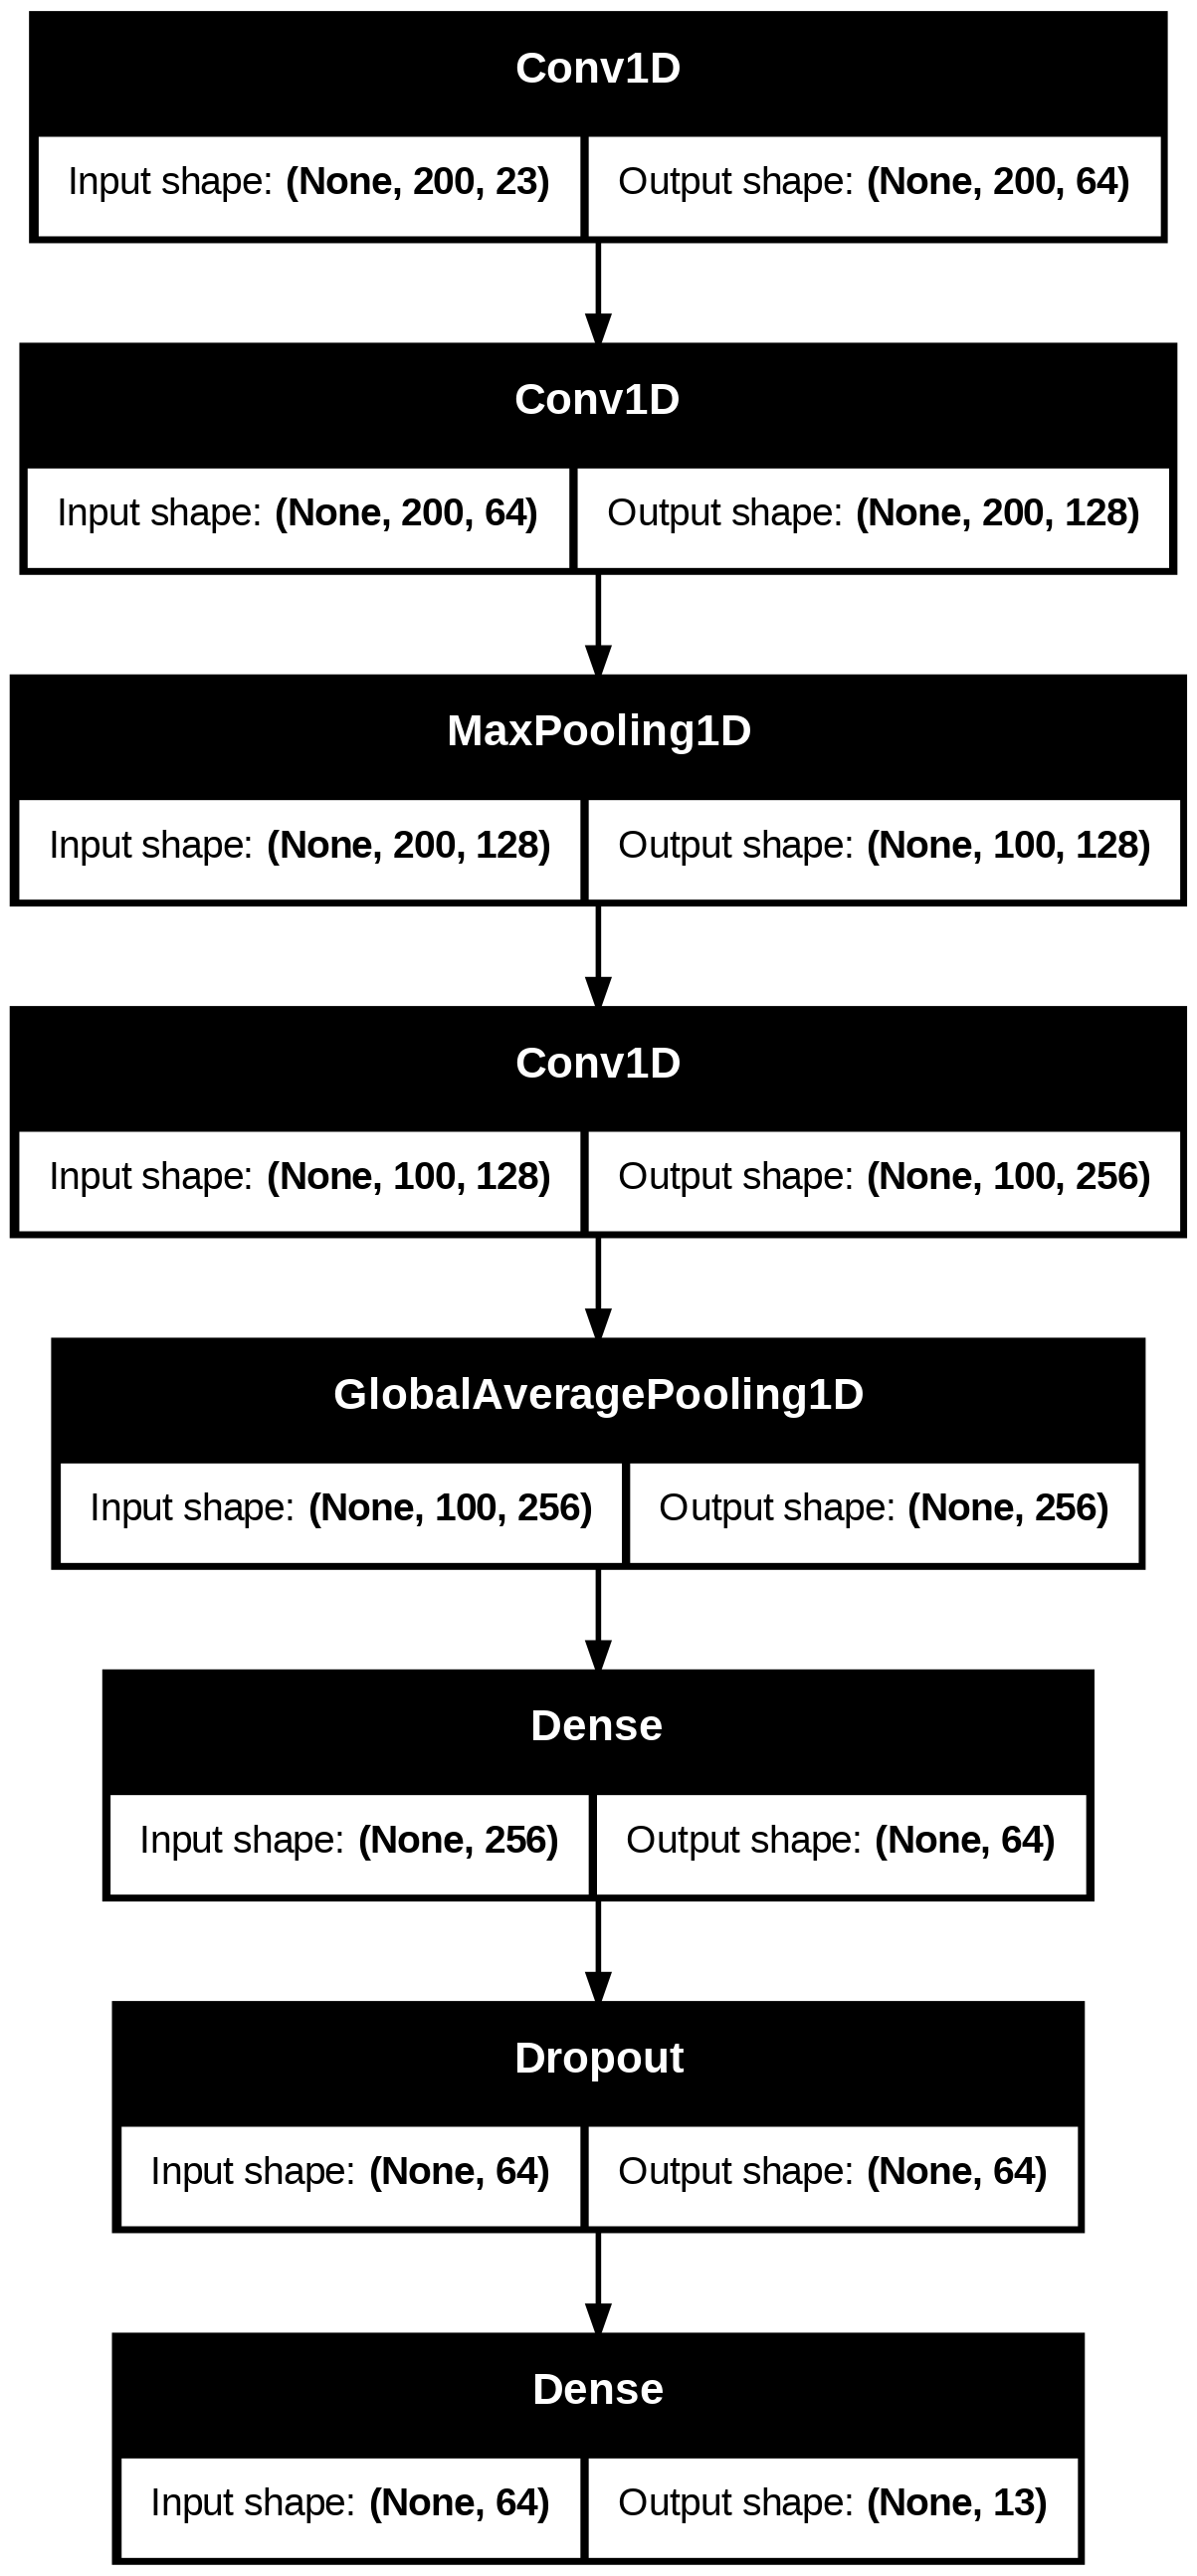

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
callbacks = [
            ModelCheckpoint(
                "mhealth_CNN_best.h5",
                save_best_only=True,
                monitor="val_sparse_categorical_accuracy",
                mode='max',
                verbose=1
            ),
            EarlyStopping(
                monitor="val_sparse_categorical_accuracy",
                patience=20,
                verbose=1,
                mode='max',
                restore_best_weights=True
            )
        ]

In [ ]:
history = model.fit(
            X_train, y_train,
            epochs=100,
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 1.1751 - sparse_categorical_accuracy: 0.6254
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.80864, saving model to mhealth_CNN_best.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - loss: 1.1684 - sparse_categorical_accuracy: 0.6276 - val_loss: 0.5149 - val_sparse_categorical_accuracy: 0.8086
Epoch 2/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.1059 - sparse_categorical_accuracy: 0.9666
Epoch 2: val_sparse_categorical_accuracy improved from 0.80864 to 0.84527, saving model to mhealth_CNN_best.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - loss: 0.1057 - sparse_categorical_accuracy: 0.9666 - val_loss: 0.5284 - val_sparse_categorical_accuracy: 0.8453
Epoch 3/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0512 - sparse_categorical_accuracy: 0.9864
Epoch 3: val_sparse_categorical_accuracy did not improve from 0.84527
177/177 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - loss: 0.0513 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.8461 - val_sparse_categorical_accuracy: 0.7556
Epoch 4/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0345 - sparse_categorical_accuracy: 0.9913
Epoch 4: val_sparse_categorical_accuracy improved from 0.84527 to 0.84582, saving model to mhealth_CNN_best.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - loss: 0.0345 - sparse_categorical_accuracy: 0.9913 - val_loss: 0.6132 - val_sparse_categorical_accuracy: 0.8458
Epoch 5/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0256 - sparse_categorical_accuracy: 0.9905
Epoch 5: val_sparse_categorical_accuracy did not improve from 0.84582
177/177 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - loss: 0.0257 - sparse_categorical_accuracy: 0.9905 - val_loss: 1.2057 - val_sparse_categorical_accuracy: 0.7851
Epoch 6/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0291 - sparse_categorical_accuracy: 0.9915
Epoch 6: val_sparse_categorical_accuracy improved from 0.84582 to 0.87917, saving model to mhealth_CNN_best.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - loss: 0.0292 - sparse_categorical_accuracy: 0.9915 - val_loss: 0.4377 - val_sparse_categorical_accuracy: 0.8792
Epoch 7/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0499 - sparse_categorical_accuracy: 0.9829
Epoch 7: val_sparse_categorical_accuracy did not improve from 0.87917
177/177 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - loss: 0.0498 - sparse_categorical_accuracy: 0.9829 - val_loss: 0.6780 - val_sparse_categorical_accuracy: 0.8622
Epoch 8/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0284 - sparse_categorical_accuracy: 0.9930
Epoch 8: val_sparse_categorical_accuracy did not improve from 0.87917
177/177 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - loss: 0.0285 - sparse_categorical_accuracy: 0.9930 - val_loss: 0.4825 - val_sparse_categorical_accuracy: 0.8606
Epoch 9/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0241 - sparse_categorical_accuracy: 0.9935
Epoch 9: val_sparse_categorical_accuracy improved from 0.87917 to 0.

177/177 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - loss: 0.0241 - sparse_categorical_accuracy: 0.9935 - val_loss: 0.2565 - val_sparse_categorical_accuracy: 0.9224
Epoch 10/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0207 - sparse_categorical_accuracy: 0.9952
Epoch 10: val_sparse_categorical_accuracy did not improve from 0.92236
177/177 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - loss: 0.0207 - sparse_categorical_accuracy: 0.9952 - val_loss: 0.4610 - val_sparse_categorical_accuracy: 0.8633
Epoch 11/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0167 - sparse_categorical_accuracy: 0.9939
Epoch 11: val_sparse_categorical_accuracy did not improve from 0.92236
177/177 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - loss: 0.0168 - sparse_categorical_accuracy: 0.9939 - val_loss: 0.3817 - val_sparse_categorical_accuracy: 0.8972
Epoch 12/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0191 - sparse_categorical_accuracy: 0.9936
Epoch 12: val_sparse_categorical_accuracy did not improve from 

In [ ]:
# 모델 평가
model = tf.keras.models.load_model("mhealth_CNN_best.h5")

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {test_acc * 100:.2f}%")
print(f"Validation loss: {test_loss:.4f}")

Training accuracy: 99.72%
Training loss: 0.0076
Validation accuracy: 92.24%
Validation loss: 0.2565


In [ ]:
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)
y_test_seq = y_test.flatten()

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       140
           1     0.9935    0.9935    0.9935       154
           2     0.9500    0.4935    0.6496       154
           3     0.9935    1.0000    0.9967       153
           4     1.0000    0.9870    0.9935       154
           5     0.9871    0.9935    0.9903       154
           6     0.9366    1.0000    0.9673       133
           7     0.6338    0.9574    0.7627       141
           8     0.9924    0.8973    0.9424       146
           9     0.9563    1.0000    0.9776       153
          10     1.0000    0.9870    0.9935       154
          11     0.9935    1.0000    0.9968       154
          12     0.9800    1.0000    0.9899        49

    accuracy                         0.9429      1839
   macro avg     0.9551    0.9469    0.9426      1839
weighted avg     0.9557    0.9429    0.9404      1839



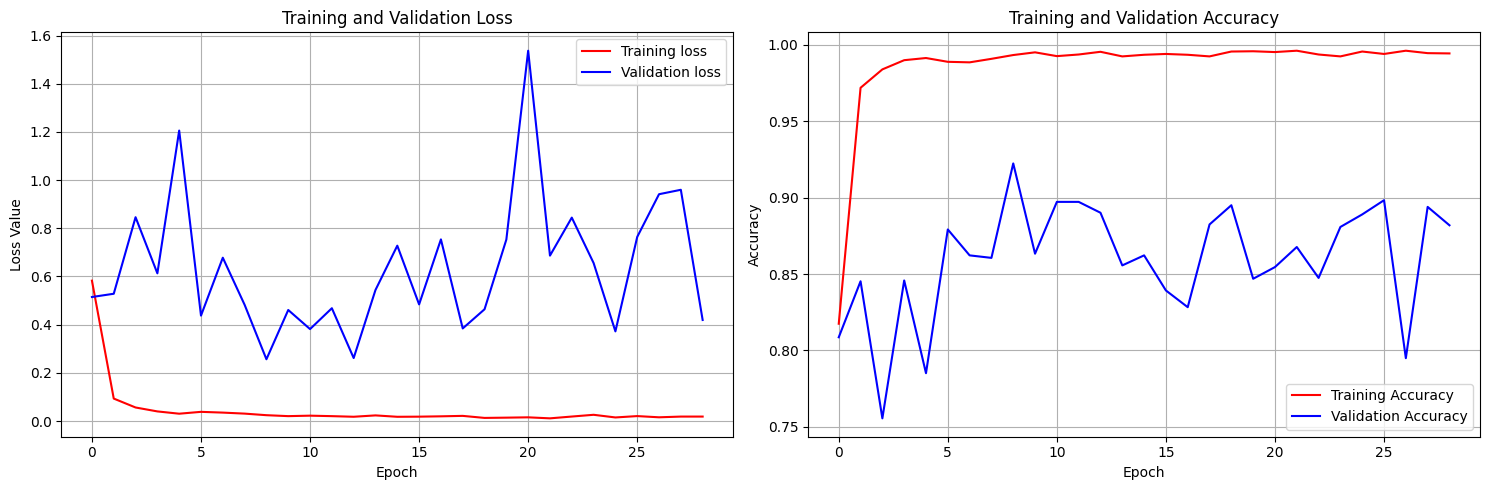

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

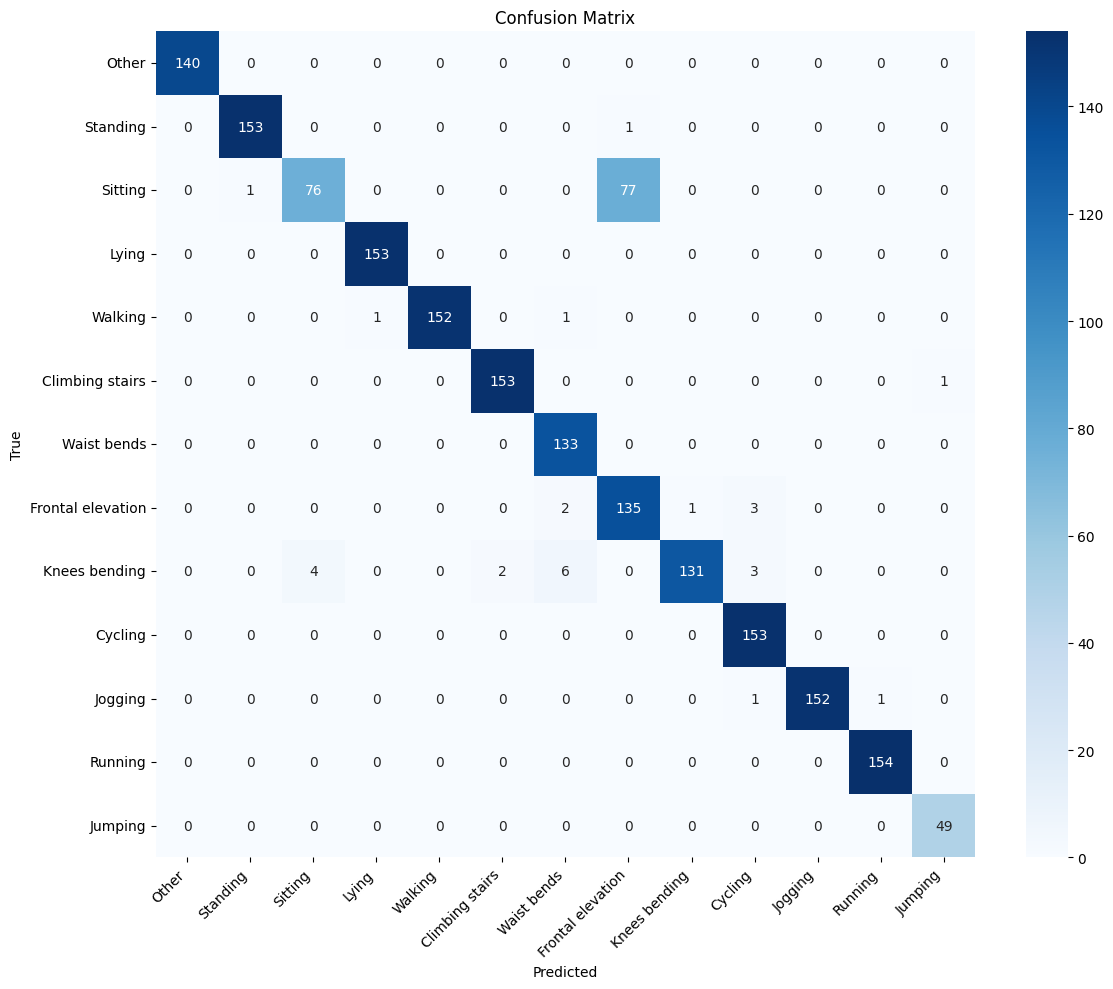

In [ ]:
cm = confusion_matrix(y_test_seq, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

activity_names = [
    'Other', 'Standing', 'Sitting', 'Lying', 'Walking',
    'Climbing stairs', 'Waist bends', 'Frontal elevation',
    'Knees bending', 'Cycling', 'Jogging', 'Running', 'Jumping'
]

n_classes = len(np.unique(y_test_seq))
if n_classes <= len(activity_names):
    plt.gca().set_xticklabels(activity_names[:n_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(activity_names[:n_classes], rotation=0)

plt.tight_layout()
plt.show()

## Model 2
- Conv1D layer 2 -> pooling -> Conv1D layer 2 -> pooling -> Conv1D layer 1

In [ ]:
input_shape = (200, 23)
num_classes = 13

model = Sequential([
    Input(shape=input_shape), # (time, channels) = (200, 23)

    Conv1D(64, kernel_size=3, padding='same', activation='relu'),
    Conv1D(128, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),

    Conv1D(128, kernel_size=3, padding='same', activation='relu'),
    Conv1D(128, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),

    Conv1D(256, kernel_size=3, padding='same', activation='relu'),

    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
        )

print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 200, 64)        │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 200, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 100, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 100, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 50, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,597 (951.55 KB)

 Trainable params: 243,597 (951.55 KB)

 Non-trainable params: 0 (0.00 B)

None


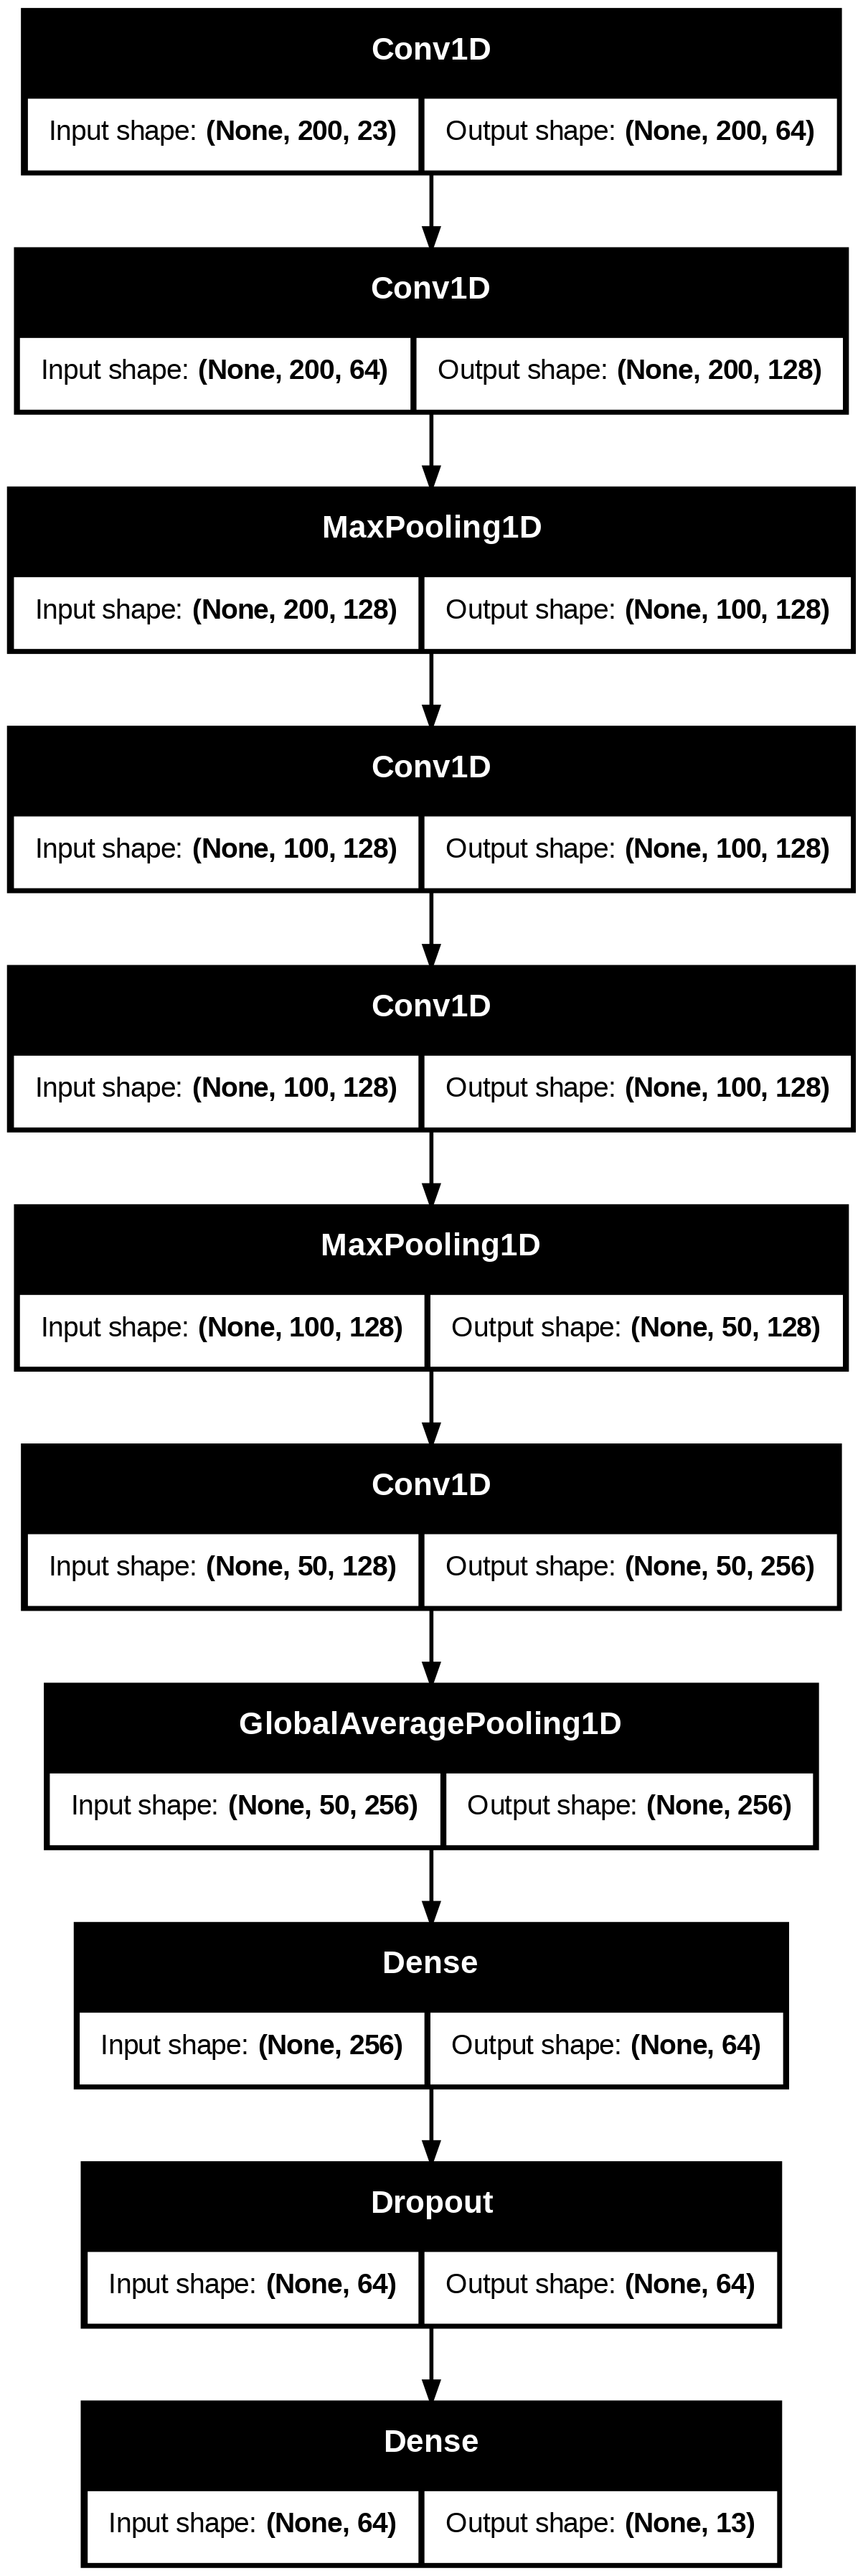

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
callbacks = [
            ModelCheckpoint(
                "mhealth_CNN_best2.h5",
                save_best_only=True,
                monitor="val_sparse_categorical_accuracy",
                mode='max',
                verbose=1
            ),
            EarlyStopping(
                monitor="val_sparse_categorical_accuracy",
                patience=20,
                verbose=1,
                mode='max',
                restore_best_weights=True
            )
        ]

In [ ]:
history = model.fit(
            X_train, y_train,
            epochs=100,
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 1.3393 - sparse_categorical_accuracy: 0.5613
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.76545, saving model to mhealth_CNN_best2.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 24s 122ms/step - loss: 1.3357 - sparse_categorical_accuracy: 0.5624 - val_loss: 0.7186 - val_sparse_categorical_accuracy: 0.7654
Epoch 2/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.1066 - sparse_categorical_accuracy: 0.9676
Epoch 2: val_sparse_categorical_accuracy improved from 0.76545 to 0.81192, saving model to mhealth_CNN_best2.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 40s 115ms/step - loss: 0.1065 - sparse_categorical_accuracy: 0.9677 - val_loss: 0.5229 - val_sparse_categorical_accuracy: 0.8119
Epoch 3/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0647 - sparse_categorical_accuracy: 0.9802
Epoch 3: val_sparse_categorical_accuracy improved from 0.81192 to 0.82285, saving model to mhealth_CNN_best2.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - loss: 0.0647 - sparse_categorical_accuracy: 0.9802 - val_loss: 0.6564 - val_sparse_categorical_accuracy: 0.8229
Epoch 4/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0407 - sparse_categorical_accuracy: 0.9871
Epoch 4: val_sparse_categorical_accuracy improved from 0.82285 to 0.82941, saving model to mhealth_CNN_best2.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - loss: 0.0407 - sparse_categorical_accuracy: 0.9871 - val_loss: 0.6907 - val_sparse_categorical_accuracy: 0.8294
Epoch 5/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0532 - sparse_categorical_accuracy: 0.9854
Epoch 5: val_sparse_categorical_accuracy improved from 0.82941 to 0.85511, saving model to mhealth_CNN_best2.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - loss: 0.0531 - sparse_categorical_accuracy: 0.9854 - val_loss: 0.7949 - val_sparse_categorical_accuracy: 0.8551
Epoch 6/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0369 - sparse_categorical_accuracy: 0.9915
Epoch 6: val_sparse_categorical_accuracy did not improve from 0.85511
177/177 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - loss: 0.0370 - sparse_categorical_accuracy: 0.9915 - val_loss: 1.3148 - val_sparse_categorical_accuracy: 0.7354
Epoch 7/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0431 - sparse_categorical_accuracy: 0.9882
Epoch 7: val_sparse_categorical_accuracy did not improve from 0.85511
177/177 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - loss: 0.0431 - sparse_categorical_accuracy: 0.9882 - val_loss: 0.7854 - val_sparse_categorical_accuracy: 0.8491
Epoch 8/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0298 - sparse_categorical_accuracy: 0.9924
Epoch 8: val_sparse_categorical_accuracy improved from 0.85511 to

177/177 ━━━━━━━━━━━━━━━━━━━━ 19s 100ms/step - loss: 0.0298 - sparse_categorical_accuracy: 0.9924 - val_loss: 0.9594 - val_sparse_categorical_accuracy: 0.8671
Epoch 9/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0239 - sparse_categorical_accuracy: 0.9938
Epoch 9: val_sparse_categorical_accuracy did not improve from 0.86714
177/177 ━━━━━━━━━━━━━━━━━━━━ 22s 110ms/step - loss: 0.0241 - sparse_categorical_accuracy: 0.9937 - val_loss: 0.5935 - val_sparse_categorical_accuracy: 0.8278
Epoch 10/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0290 - sparse_categorical_accuracy: 0.9927
Epoch 10: val_sparse_categorical_accuracy did not improve from 0.86714
177/177 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - loss: 0.0290 - sparse_categorical_accuracy: 0.9927 - val_loss: 1.6182 - val_sparse_categorical_accuracy: 0.8070
Epoch 11/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0230 - sparse_categorical_accuracy: 0.9939
Epoch 11: val_sparse_categorical_accuracy did not improve from

177/177 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - loss: 0.0285 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.7068 - val_sparse_categorical_accuracy: 0.8704
Epoch 15/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0254 - sparse_categorical_accuracy: 0.9929
Epoch 15: val_sparse_categorical_accuracy did not improve from 0.87042
177/177 ━━━━━━━━━━━━━━━━━━━━ 19s 106ms/step - loss: 0.0253 - sparse_categorical_accuracy: 0.9929 - val_loss: 1.4572 - val_sparse_categorical_accuracy: 0.8480
Epoch 16/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0271 - sparse_categorical_accuracy: 0.9934
Epoch 16: val_sparse_categorical_accuracy improved from 0.87042 to 0.87589, saving model to mhealth_CNN_best2.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - loss: 0.0270 - sparse_categorical_accuracy: 0.9934 - val_loss: 0.3991 - val_sparse_categorical_accuracy: 0.8759
Epoch 17/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0123 - sparse_categorical_accuracy: 0.9962
Epoch 17: val_sparse_categorical_accuracy did not improve from 0.87589
177/177 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - loss: 0.0123 - sparse_categorical_accuracy: 0.9962 - val_loss: 0.5162 - val_sparse_categorical_accuracy: 0.8398
Epoch 18/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0163 - sparse_categorical_accuracy: 0.9952
Epoch 18: val_sparse_categorical_accuracy did not improve from 0.87589
177/177 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - loss: 0.0164 - sparse_categorical_accuracy: 0.9952 - val_loss: 0.8493 - val_sparse_categorical_accuracy: 0.8595
Epoch 19/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0582 - sparse_categorical_accuracy: 0.9840
Epoch 19: val_sparse_categorical_accuracy did not improve fr

177/177 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - loss: 0.0260 - sparse_categorical_accuracy: 0.9910 - val_loss: 0.4586 - val_sparse_categorical_accuracy: 0.8770
Epoch 21/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0240 - sparse_categorical_accuracy: 0.9916
Epoch 21: val_sparse_categorical_accuracy improved from 0.87698 to 0.88573, saving model to mhealth_CNN_best2.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 22s 113ms/step - loss: 0.0239 - sparse_categorical_accuracy: 0.9916 - val_loss: 1.0132 - val_sparse_categorical_accuracy: 0.8857
Epoch 22/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0251 - sparse_categorical_accuracy: 0.9931
Epoch 22: val_sparse_categorical_accuracy did not improve from 0.88573
177/177 ━━━━━━━━━━━━━━━━━━━━ 18s 100ms/step - loss: 0.0251 - sparse_categorical_accuracy: 0.9931 - val_loss: 1.4767 - val_sparse_categorical_accuracy: 0.8343
Epoch 23/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0094 - sparse_categorical_accuracy: 0.9950
Epoch 23: val_sparse_categorical_accuracy did not improve from 0.88573
177/177 ━━━━━━━━━━━━━━━━━━━━ 23s 115ms/step - loss: 0.0094 - sparse_categorical_accuracy: 0.9950 - val_loss: 1.6579 - val_sparse_categorical_accuracy: 0.8201
Epoch 24/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0317 - sparse_categorical_accuracy: 0.9900
Epoch 24: val_sparse_categorical_accuracy did not improve f

177/177 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - loss: 0.0232 - sparse_categorical_accuracy: 0.9902 - val_loss: 0.2729 - val_sparse_categorical_accuracy: 0.9147
Epoch 27/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0099 - sparse_categorical_accuracy: 0.9969
Epoch 27: val_sparse_categorical_accuracy did not improve from 0.91471
177/177 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - loss: 0.0100 - sparse_categorical_accuracy: 0.9969 - val_loss: 1.5179 - val_sparse_categorical_accuracy: 0.8387
Epoch 28/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0126 - sparse_categorical_accuracy: 0.9961
Epoch 28: val_sparse_categorical_accuracy did not improve from 0.91471
177/177 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - loss: 0.0126 - sparse_categorical_accuracy: 0.9961 - val_loss: 1.3316 - val_sparse_categorical_accuracy: 0.7660
Epoch 29/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0199 - sparse_categorical_accuracy: 0.9945
Epoch 29: val_sparse_categorical_accuracy did not improve fr

In [ ]:
# 모델 평가
model = tf.keras.models.load_model("mhealth_CNN_best2.h5")

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {test_acc * 100:.2f}%")
print(f"Validation loss: {test_loss:.4f}")

Training accuracy: 99.73%
Training loss: 0.0061
Validation accuracy: 91.47%
Validation loss: 0.2729


In [ ]:
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)
y_test_seq = y_test.flatten()

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       140
           1     0.9686    1.0000    0.9840       154
           2     1.0000    0.4935    0.6609       154
           3     0.9935    1.0000    0.9967       153
           4     1.0000    0.9935    0.9967       154
           5     1.0000    0.9870    0.9935       154
           6     0.9924    0.9850    0.9887       133
           7     0.6419    0.9787    0.7753       141
           8     0.9931    0.9863    0.9897       146
           9     0.9808    1.0000    0.9903       153
          10     1.0000    0.9870    0.9935       154
          11     1.0000    0.9935    0.9967       154
          12     0.9423    1.0000    0.9703        49

    accuracy                         0.9505      1839
   macro avg     0.9625    0.9542    0.9489      1839
weighted avg     0.9651    0.9505    0.9479      1839



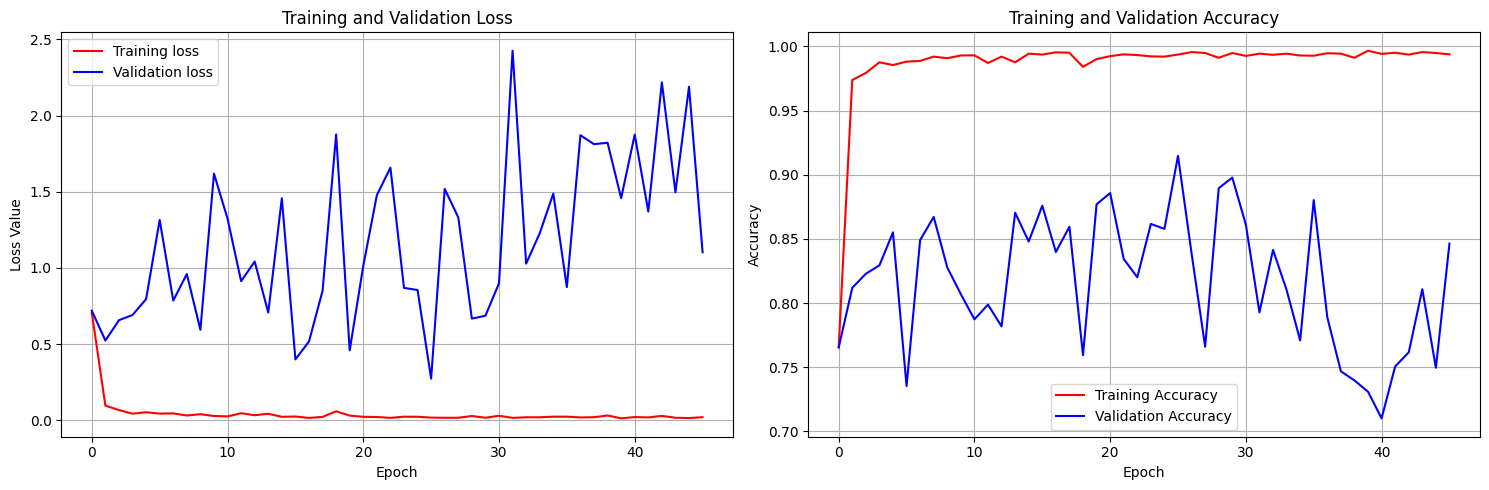

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

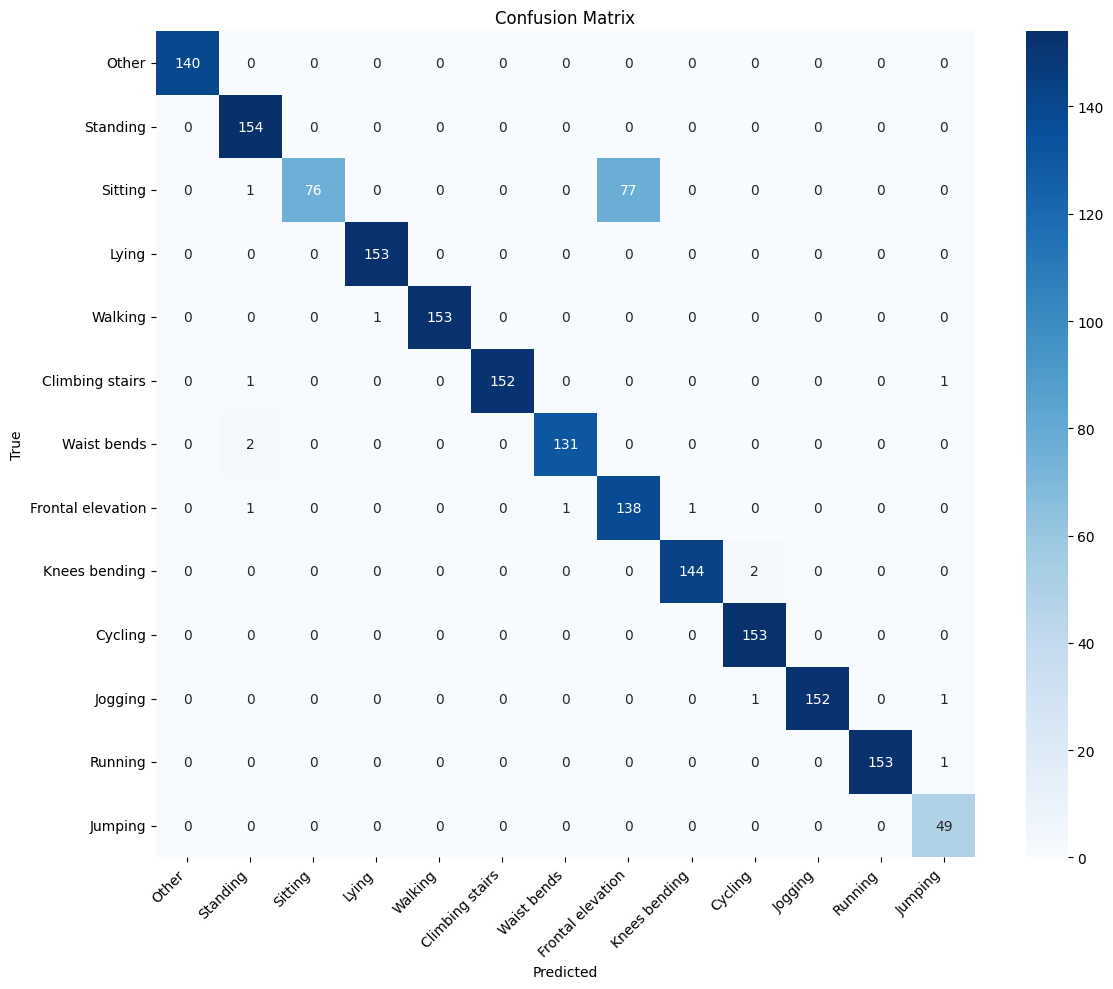

In [ ]:
cm = confusion_matrix(y_test_seq, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

activity_names = [
    'Other', 'Standing', 'Sitting', 'Lying', 'Walking',
    'Climbing stairs', 'Waist bends', 'Frontal elevation',
    'Knees bending', 'Cycling', 'Jogging', 'Running', 'Jumping'
]

n_classes = len(np.unique(y_test_seq))
if n_classes <= len(activity_names):
    plt.gca().set_xticklabels(activity_names[:n_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(activity_names[:n_classes], rotation=0)

plt.tight_layout()
plt.show()